In [1]:
import math
import json

import keras
import librosa
import os

import numpy
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
print(tf.config.list_physical_devices('GPU'))



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
def preprocess(dataset_path, num_mfcc=40, n_fft=2048, hop_length=512, num_segment=10):
    # all_mfcc = np.empty([1000 * num_segment, 40, 130])
    # all_spec = np.empty([1000 * num_segment, 1025, 130])
    all_mel = np.empty([1000 * num_segment, 128, 130], dtype=np.float32)
    # all_chroma = np.empty([1000 * num_segment, 12, 130])
    labels = np.empty([1000 * num_segment])
    sample_rate = 22050
    sample_per_segment = int(sample_rate*30/num_segment)

    count = 0
    for label_idx, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath == dataset_path:
            continue

        for f in sorted(filenames):
            if not f.endswith('.wav'):
                continue
            file_path = str(str(dirpath).split('\\')[-1]) + '/' + str(f)
            print("Track Name", file_path)

            try:
                y, sr = librosa.load(path=dirpath + "\\" + f, sr=sample_rate)
            except:
                print("Exception")
                continue

            for n in range(num_segment):
                segment = y[sample_per_segment*n: sample_per_segment*(n + 1)]
                # Get mel-spectrogram
                mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=n_fft, hop_length=hop_length, dtype=np.float32)
                mel_db = librosa.power_to_db(mel)
                if mel_db.shape[0] == all_mel.shape[1] and mel_db.shape[1] == all_mel.shape[2]:
                    all_mel[count] = mel_db
                    labels[count] = label_idx - 1
                    count += 1

    # all_mfcc = all_mfcc.astype(np.float32)
    # all_spec = all_spec.astype(np.float32)
    # all_mel = all_mel.astype(np.float32)
    # all_chroma = all_chroma.astype(np.float32)
    print(count)
    all_mel = np.delete(all_mel, np.s_[count:], axis=0)
    labels = np.delete(labels, np.s_[count:])
    return all_mel, labels

In [29]:
def prepare_datasets(test_size, validation_size):

    mel, labels = preprocess(r"C:\Users\dpetr\Desktop\sxoli\music genre classification\MFCC-CNN\Data\genres_original")

    x_train, x_test, y_train, y_test = train_test_split(mel, labels, test_size=test_size)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=validation_size)

    x_train = x_train[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]
    x_test = x_test[..., np.newaxis]

    return x_train, x_test, x_validation, y_train, y_test, y_validation


x_train, x_test, x_validation, y_train, y_test, y_validation = prepare_datasets(test_size=0.2, validation_size=0.25)

print(x_train.shape, x_validation.shape, x_test.shape)

Track Name blues/blues.00000.wav
Track Name blues/blues.00001.wav
Track Name blues/blues.00002.wav
Track Name blues/blues.00003.wav
Track Name blues/blues.00004.wav
Track Name blues/blues.00005.wav
Track Name blues/blues.00006.wav
Track Name blues/blues.00007.wav
Track Name blues/blues.00008.wav
Track Name blues/blues.00009.wav
Track Name blues/blues.00010.wav
Track Name blues/blues.00011.wav
Track Name blues/blues.00012.wav
Track Name blues/blues.00013.wav
Track Name blues/blues.00014.wav
Track Name blues/blues.00015.wav
Track Name blues/blues.00016.wav
Track Name blues/blues.00017.wav
Track Name blues/blues.00018.wav
Track Name blues/blues.00019.wav
Track Name blues/blues.00020.wav
Track Name blues/blues.00021.wav
Track Name blues/blues.00022.wav
Track Name blues/blues.00023.wav
Track Name blues/blues.00024.wav
Track Name blues/blues.00025.wav
Track Name blues/blues.00026.wav
Track Name blues/blues.00027.wav
Track Name blues/blues.00028.wav
Track Name blues/blues.00029.wav
Track Name

In [2]:
mel_file = np.load(r'C:\Users\dpetr\Desktop\sxoli\Level 3\Individual\datasets\GTZAN\mel_spectogram_train_validation_test.npz')

mel_train = mel_file['mel_spec_train']
mel_validation = mel_file['mel_spec_validation']
mel_test = mel_file['mel_spec_test']

y_train = mel_file['y_train']
y_validation = mel_file['y_validation']
y_test= mel_file['y_test']

In [4]:
print("X shape: ", mel_train.shape, mel_validation.shape, mel_test.shape)
print("Y shape: ", y_train.shape, y_validation.shape, y_test.shape)


X shape:  (5991, 128, 130, 1) (1997, 128, 130, 1) (1998, 128, 130, 1)
Y shape:  (5991,) (1997,) (1998,)


In [4]:
# maximum = np.amax(mel_train)
# mel_train = mel_train/np.amax(maximum)
# mel_validation = mel_validation/np.amax(maximum)
# mel_test = mel_test/np.amax(maximum)

In [5]:
mean = np.mean(mel_train)
std = np.std(mel_train)
mel_train = (mel_train - mean) / std
mel_test = (mel_test - mean) / std
mel_validation = (mel_validation - mean) / std

In [7]:
print(mean)
print(std)

-12.67344
16.546448


In [37]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0. 596.]
 [  1. 554.]
 [  2. 570.]
 [  3. 610.]
 [  4. 630.]
 [  5. 585.]
 [  6. 623.]
 [  7. 584.]
 [  8. 601.]
 [  9. 638.]]


In [31]:
def build_model(input_shape):

    #create model
    model = keras.Sequential()

    #1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.2))

    #2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.2))

    #3rd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3), strides=(2,2), padding='same'))
    # model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.2))


    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(512, activation='relu')) # 512 best
    model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.6))

    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [32]:
input_shape = mel_train[0].shape
model = build_model(input_shape)
optimizer = keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [33]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 126, 128, 64)      640       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 63, 64, 64)       0         
 g2D)                                                            
                                                                 
 re_lu_26 (ReLU)             (None, 63, 64, 64)        0         
                                                                 
 dropout_40 (Dropout)        (None, 63, 64, 64)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 61, 62, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 31, 31, 128)      0         
 g2D)                                                 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 126, 128, 64)      640       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 63, 64, 64)       0         
 g2D)                                                            
                                                                 
 re_lu_26 (ReLU)             (None, 63, 64, 64)        0         
                                                                 
 dropout_40 (Dropout)        (None, 63, 64, 64)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 61, 62, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 31, 31, 128)      0         
 g2D)                                                 

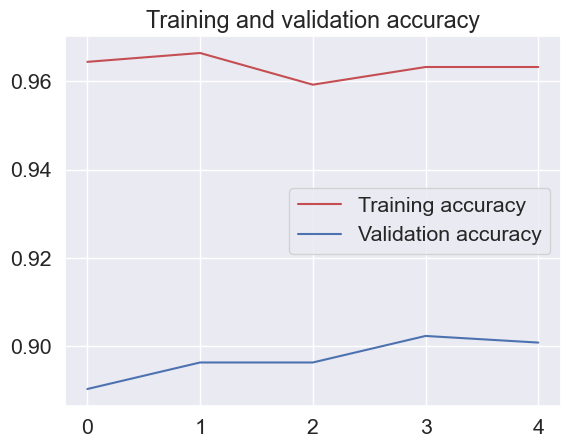

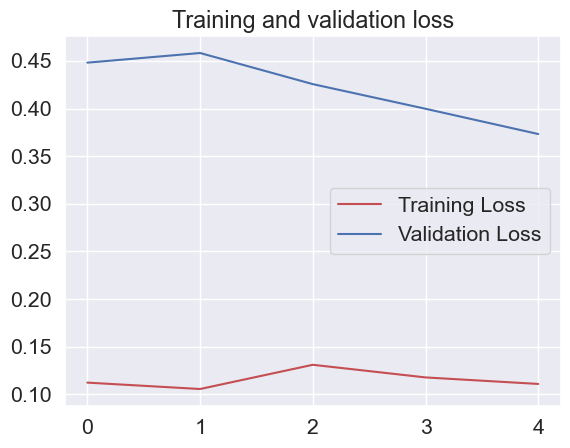

Accuracy on test set is:0.9054054021835327


In [93]:


model.summary()

history = model.fit(mel_train, y_train,
          validation_data=(mel_validation, y_validation),
          epochs=5,
          batch_size=32
          )

test_error, test_accuracy = model.evaluate(mel_test, y_test, verbose=1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy' + str())
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print("Accuracy on test set is:{}".format(test_accuracy))



63/63 [==============================] - 1s 13ms/step


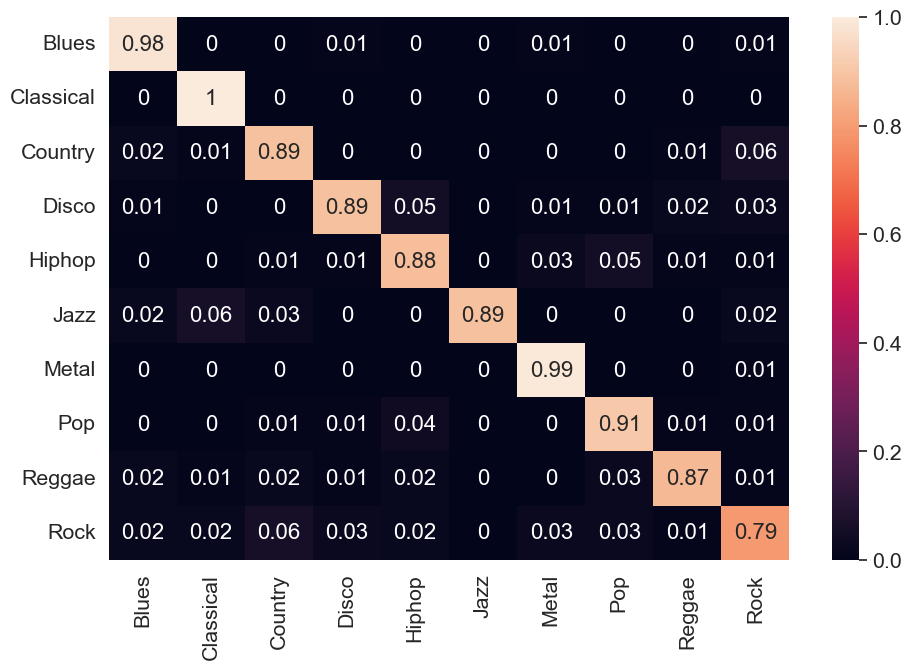

In [83]:
predictions = model.predict(mel_test, batch_size=32, verbose=1)
predicted_indexes = []
for prediction in predictions:
    predicted_indexes.append(np.argmax(prediction))
predicted_indexes
conf_mat = confusion_matrix(y_test, predicted_indexes, normalize= 'true')
conf_mat = np.round(conf_mat, 2)
conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)
plt.figure(figsize = (10,7), dpi = 100)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()

In [74]:
model.save('saved_models/CNN-MEL-91,5test')

INFO:tensorflow:Assets written to: saved_models/CNN-MEL-91,5test\assets


INFO:tensorflow:Assets written to: saved_models/CNN-MEL-91,5test\assets
